## Matrix 합치기
- LF 4개 + BM-MSC 3개 + NP 4개 + Fibula 4개
- 우리의 OLF 4개, *LF* 2개, *Normal* 4개도 합쳐보자

In [88]:
from Bio import SeqIO
from biomart import BiomartServer
import pandas as pd
import numpy as np
import os
import palettable
from reComBat import reComBat
batch_No = 0
batch_list = []
# batch_list = [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6]
tabl = palettable.tableau.Tableau_20.mpl_colors

### GSE188760 (O2, C2)는 형식이 좀 특이해서 parsing 하기

In [89]:
DIR = "/data/project/OPLL/0.rnaraw/99.public/GSE188760/03.matrix"
OUTPUT_TSV = DIR + "/GSE188760.FPKM.tsv"
cnt = 0

# Display the filenames
for filename in sorted(os.listdir(DIR))  :
    if os.path.isfile (os.path.join ( DIR, filename)) == False:
        continue
    if "results" in filename:

        INPUT_TSV = DIR + "/" + filename
        SAMPLE_ID = filename.split("_")[1].split(".")[0]

        df = pd.read_csv (INPUT_TSV, sep = "\t")
        print ("{}\t{}".format (filename, df.shape))
        df[['Column1', 'GENE_SYMBOL']] = df['gene_id'].str.split('_', 1, expand = True)
        df[['ENSEMBL_ID', 'Column2']] = df['Column1'].str.split('.', 1, expand = True)
        #df = df.drop (['gene_id', 'transcript_id(s)', 'length', 'effective_length', 'Column1', 'Column2'], axis = 1)
        df = df.loc [:, ["ENSEMBL_ID", "GENE_SYMBOL", "expected_count"] ]
        df.rename(columns = {"expected_count" : SAMPLE_ID }, inplace = True)

        if cnt == 0:
            df_concat = df
        else:
            df_concat = pd.merge (df_concat, df, how = 'outer')
        
        cnt = cnt + 1
        batch_list.append (batch_No)

batch_No = batch_No + 1
df_concat = df_concat.drop_duplicates()          # 왜인진 모르겠으나 duplicated row가 생김
df_concat.to_csv ( OUTPUT_TSV, sep = "\t", index = False)
df_concat.shape

GSM5689354_O1.genes.results	(60651, 7)
GSM5689355_O2.genes.results	(60651, 7)
GSM5689356_C1.genes.results	(60651, 7)
GSM5689357_C2.genes.results	(60651, 7)


(60651, 6)

### GSE197172 (BM-MSC)는 n*3인데 3개 matrix를 합쳐주기

In [90]:
DIR = "/data/project/OPLL/0.rnaraw/99.public/GSE197172/03.matrix"
cnt_BMMSC = 0

# Display the filenames
for filename in sorted(os.listdir(DIR))  :
    if os.path.isfile (os.path.join ( DIR, filename)) == False:
        continue
    if "tab" in filename:
        INPUT_TSV = DIR + "/" + filename
        SAMPLE_ID = filename.split(".")[0].split("_")[1]

        df = pd.read_csv (INPUT_TSV, sep = "\t")
        print ("{}\t{}".format (filename, df.shape ) )
        df = df.iloc [:, [0, 1]] 
        df.columns = ["GENE_SYMBOL", SAMPLE_ID]
        
        if cnt_BMMSC == 0:
            df_concat_BMMSC = df
        else:
            df_concat_BMMSC= pd.merge (df_concat_BMMSC, df, how = 'outer')
        
        cnt_BMMSC = cnt_BMMSC + 1
        batch_list.append (batch_No)

batch_No = batch_No + 1
df_concat_BMMSC = df_concat_BMMSC.iloc [3:].reset_index(drop = True)

df_concat = pd.merge (df_concat, df_concat_BMMSC ,   left_on = "GENE_SYMBOL", right_on = "GENE_SYMBOL", how = "left").fillna (0)

GSM5910541_Lin2-1.STAR.ReadsPerGene.out.tab	(26478, 4)
GSM5910542_Lin2-2.STAR.ReadsPerGene.out.tab	(26478, 4)
GSM5910543_Lin2-3.STAR.ReadsPerGene.out.tab	(26478, 4)


### GSE186542 (NP), GSE220630 (Fibula)는 4개씩 얻기

In [91]:
DIR = "/data/project/OPLL/0.rnaraw/99.public"
DIR_list = [DIR + "/GSE186542/03.matrix/GSE186542_gene_expression.txt",  
                    DIR + "/GSE220630/03.matrix/GSE220630_norm_counts.tsv" ]

for INPUT_TSV in DIR_list:
    df = pd.read_csv (INPUT_TSV, sep = "\t")
    print ("{}\t{}".format ( INPUT_TSV.split("/")[-1], df.shape))
    df_concat = pd.merge (df_concat, df.iloc[ : , [0, -1, -2, -3, -4]] ,   left_on = "ENSEMBL_ID", right_on = "ENSEMBL_ID", how = "left")
    batch_list = batch_list + [batch_No] * 4
    batch_No = batch_No + 1

df_concat = df_concat.fillna(0)   # Missing value -> 0

GSE186542_gene_expression.txt	(58302, 10)
GSE220630_norm_counts.tsv	(60666, 31)


### OLF 4개, LF 3개, NORMAL 4개 얻어보기 (raw count)

In [92]:
# DIR = "/data/project/OPLL/0.rnaraw/04.matrix"
# OLF_DIR_list = [DIR + "/230119/230119-OLF.tsv", DIR + "/230126/230126-OLF.tsv", DIR + "/230207/230207-OLF.tsv", DIR + "/230222/230222-OLF.tsv" ]
# LF_DIR_list = [DIR + "/230207/230207-LF.tsv", DIR + "/230222/230222-LF.tsv" ]
# NORMAL_DIR_list = [DIR + "/230119/230119-NORMAL.tsv", DIR + "/230126/230126-NORMAL.tsv", DIR + "/230207/230207-NORMAL.tsv", DIR + "/230222/230222-NORMAL.tsv" ]
# cnt_MY = 0

# for INPUT_TSV in OLF_DIR_list + LF_DIR_list + NORMAL_DIR_list:
#     df = pd.read_csv (INPUT_TSV, sep = "\t")
#     SAMPLE_ID = INPUT_TSV.split("/")[-1].split(".")[0]
#     df.columns = ["GENE_SYMBOL", SAMPLE_ID]
#     print ("{}\t{}".format ( INPUT_TSV.split("/")[-1], df.shape))

#     if cnt_MY == 0:
#         df_concat_MY = df
#     else:
#         if SAMPLE_ID.split("-")[1].split(".")[0] != df_concat_MY.columns[-1].split("-")[1] :
#             batch_No = batch_No + 1
#         df_concat_MY= pd.merge (df_concat_MY, df, how = 'outer')
#     cnt_MY = cnt_MY + 1

#     batch_list.append (batch_No)

# df_concat_MY = df_concat_MY.iloc [:-5, ]
# #df_concat_MY

# df_concat = pd.merge (df_concat, df_concat_MY ,   left_on = "GENE_SYMBOL", right_on = "GENE_SYMBOL", how = "left").fillna (0)
# df_concat

## 내 data 모으기

In [93]:
print (list ( coldata + np.max(batch_list) + 1))

[5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 9, 5, 6, 7, 9, 5, 6, 7, 8, 5, 6]


In [94]:
df = pd.read_csv ( "/data/project/OPLL/0.rnaraw/Analysis/~230316/00.PCA&Demographics/df/df_coladd.txt",  sep = "\t")
#coldata = pd.read_csv ( "/data/project/OPLL/0.rnaraw/Analysis/~230316/00.PCA&Demographics/coldata/group.txt",  sep = "\t", header = None)
coldata = [ int(line.rstrip('\n')) for line in open("/data/project/OPLL/0.rnaraw/Analysis/~230316/00.PCA&Demographics/coldata/group.txt", 'r')]
batch_list = batch_list +  list ( coldata + np.max(batch_list) )


df_concat = pd.merge (df_concat, df ,   left_on = "GENE_SYMBOL", right_on = "GENE_SYMBOL", how = "left").fillna (0)
print (df_concat.shape, len(batch_list))

(60651, 47) 45


### Batch 정리 및 Low count row 제거

In [97]:
batch_df = pd.DataFrame (batch_list)
batch_series= pd.Series (batch_list)
START_COLUMN = 2 
print ("{}개 sample\t {}개 batch\n{}".format (len(batch_list), len( np.unique(batch_list) ) , batch_list ) )

# Low count row는 제거해주기
row_averages = df_concat.iloc[:, START_COLUMN:].mean(axis=1)
df_concat = df_concat [row_averages >= 5].reset_index ( drop = True)

45개 sample	 9개 batch
[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 6, 8, 4, 5, 6, 8, 4, 5, 6, 7, 4, 5]


## Batch effect removal (reComBat)

In [99]:
# batch 제거하지 않은 것 (Transform 되어있다)
df_concat_batchunremoved = df_concat.iloc [:, START_COLUMN:].T

# batch 제거한 것 (Transform 되어있다)
combat = reComBat()
df_concat_batchremoved = combat.fit_transform(df_concat.iloc[ :, START_COLUMN:].T, batch_series)

[reComBat] 2023-05-19 14:59:11,030 Starting to fot reComBat.


ValueError: There should be at least two values for each batch.

## PCA로 뿌려보기

In [101]:
df_concat [ df_concat["GENE_SYMBOL"].isin ( ["RUNX2", "ALPL", "ENPP1", "COL6A1"]) ]

,ENSEMBL_ID,GENE_SYMBOL,O1,O2,C1,C2,Lin2-1,Lin2-2,Lin2-3,NP_degenerated_1,...,230207-NORMAL,230207-OLF,230207-SPINOUS,230222-LF,230222-NORMAL,230222-OLF,230222-SPINOUS,230316-DISH,230316-NORMAL,230316-OPLL
5521,ENSG00000124813,RUNX2,105.0,59.0,134.0,160.0,4232.0,4466.0,4209.0,511.0,...,7482.0,23709.0,7859.0,2509.0,8034.0,19110.0,4260.0,20584.0,32571.0,51774.0
8053,ENSG00000142156,COL6A1,420.0,3579.0,15434.0,22755.0,68288.0,68778.0,74825.0,78286.0,...,14727.0,267114.0,40625.0,143539.0,26227.0,101766.0,5147.0,119766.0,204937.0,94081.0
10533,ENSG00000162551,ALPL,200.0,183.0,66.0,111.0,19164.0,19572.0,27282.0,130.0,...,3825.0,23728.0,4532.0,1498.0,5635.0,4433.0,914.0,20365.0,84017.0,95242.0
16520,ENSG00000197594,ENPP1,8.0,89.0,811.0,2164.0,3810.0,4076.0,2853.0,10410.0,...,1218.0,27163.0,3219.0,3965.0,3240.0,12011.0,888.0,4494.0,4897.0,24352.0


batch_list = [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 6, 8, 4, 5, 6, 8, 4, 5, 6, 7, 4, 5]
range_of_interst = [0, 1, 2, 4, 5, 6]
index_of_interest = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 43, 44]


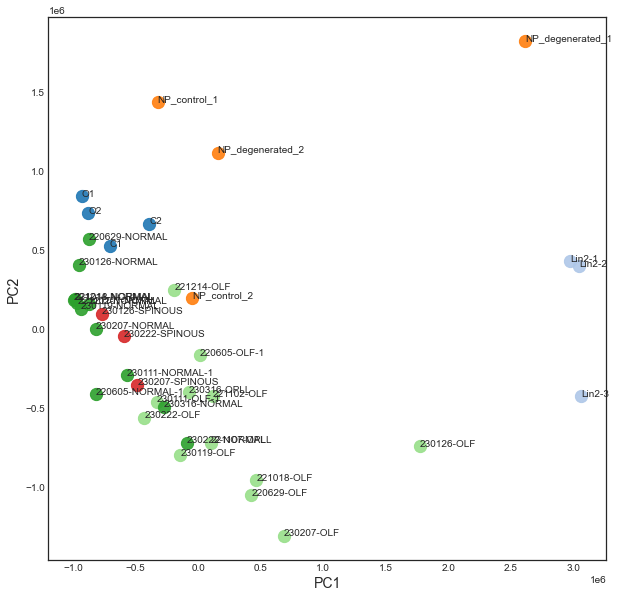

In [104]:
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
import seaborn as sns


def drawPCA (df_concat_T, range_of_interest):
    index_of_interest = [i for i in range (0, df_concat_T.shape[0]) if batch_list[i] in range_of_interest]


    print ("batch_list = {}\nrange_of_interst = {}\nindex_of_interest = {}".format (batch_list, range_of_interest, index_of_interest))
    
    df_concat_interest_T = df_concat_T.iloc [ index_of_interest , : ]
    

    pca = PCA(n_components=2)
    pca.fit (df_concat_interest_T )
    df_concat_pca = pca.transform( df_concat_interest_T )

    plt.rcParams["font.family"] = 'arial'
    plt.style.use("seaborn-white")

    fig, ax = plt.subplots (figsize = (10, 10))
    # ax.axis([np.min(np_vaf[:, 0]) * 2.1,  np.max(np_vaf[:, 0]) * 2.1,  np.min(np_vaf[:, 1]) * 2.1,  np.max(np_vaf[:, 1]) * 2.1])

    for i in range ( df_concat_pca.shape[0] ):
        plt.scatter (x = df_concat_pca [i, 0], y = df_concat_pca [i, 1], color = tabl [ batch_list [ index_of_interest[i] ] ] ,  s = 150, alpha = 0.9) 
        plt.text( df_concat_pca [i, 0], df_concat_pca [i, 1],  df_concat_interest_T.index [i]  )

    ax.set_xlabel("PC1", fontdict = {"fontsize" : 14})
    ax.set_ylabel("PC2", fontdict = {"fontsize" : 14})

    plt.show()

drawPCA (df_concat_batchunremoved, [0, 1, 2, 4, 5, 6])